In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [4]:
import pandas as pd
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import deepmatcher as dm
import torch

In [5]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [6]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')
model = model.cuda()

In [7]:
negatives = return_layer_input('../../Structured/Beer/'
                                                                         ,'negatives',64,model,
                                                                        model.classifier,device = 0)

In [8]:
positives = return_layer_input('../../Structured/Beer',
                                                                       'positives',64,model,
                                                                       model.classifier,device= 0)

In [9]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Negative analysis

In [10]:
negatives_ri,neg_ri_norms = computeRi(model.classifier,attributes,negatives,attribute_len,1)
torch.save(negatives_ri,'experiment-results/neg_ri.pt')

100%|██████████| 382/382 [00:22<00:00, 17.25it/s]


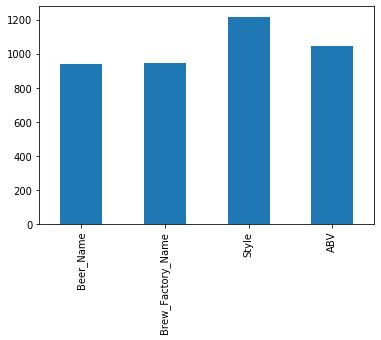

In [12]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()

## Positive analysis

In [13]:
positives_ri,pos_ri_norms = computeRi(model.classifier,attributes,positives,attribute_len,0)
torch.save(positives_ri,'experiment-results/pos_ri.pt')

100%|██████████| 68/68 [00:05<00:00, 13.24it/s]


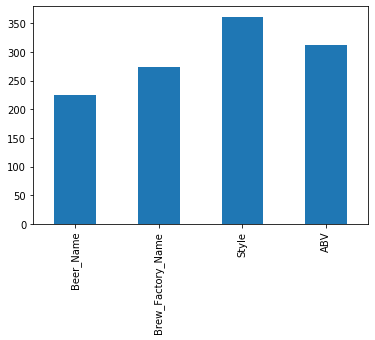

In [15]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

## Compute closer vectors

### Considering all samples

In [16]:
from utils.distance_measures import nearestNeighborsOnAttribute

In [17]:
##run this cell to load precomputed ri
positives_ri = torch.load('experiment-results/pos_ri.pt')
negatives_ri = torch.load('experiment-results/neg_ri.pt')

In [18]:
positives_nn = nearestNeighborsOnAttribute(positives,positives_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 68/68 [00:00<00:00, 507.84it/s]


In [19]:
negatives_nn = nearestNeighborsOnAttribute(negatives,negatives_ri,
                                                        positives,attributes,attribute_len)

100%|██████████| 382/382 [00:00<00:00, 633.29it/s]


In [20]:
positives_nn.to_csv('experiment-results/positivesNNhybrid.csv',index=False)
negatives_nn.to_csv('experiment-results/negativesNNhybrid.csv',index=False)

### Considering only training set

In [ ]:
train_neg = return_layer_input('../../Structured/Beer/','train_negatives',128,model,model.classifier)
train_pos = return_layer_input('../../Structured/Beer/','train_positives',128,model,model.classifier)

In [ ]:
positives_nn = calculate_nearest_neighbors_onAttributes(positives,positives_ri,
                                                       train_neg,attributes,attribute_len)

In [ ]:
negatives_nn = calculate_nearest_neighbors_onAttributes(negatives,negatives_ri,
                                                        train_pos,attributes,attribute_len)

In [ ]:
negatives_nn.to_csv('experiment-results/negativesNNhybrid_onlytrain.csv',index=False)
positives_nn.to_csv('experiment-results/positivesNNhybrid_onlytrain.csv',index=False)